In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from string import punctuation

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
csv_dd13 = pd.read_csv("dd13.csv")


## Pré-processamento

In [4]:
csv_dd13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757 entries, 0 to 1756
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Coluna ID                         1757 non-null   int64  
 1   Matrícula do Usuário Cadastrante  1745 non-null   float64
 2   Origem                            1757 non-null   object 
 3   UGB/DESC_GG (Nível 2)             1757 non-null   object 
 4   GERENCIA/AREA FABRICA (Nível 3)   1757 non-null   object 
 5   DEPARTAMENTO (Nível 5)            1757 non-null   object 
 6   Descrição                         1756 non-null   object 
 7   Nível do Acidente                 1733 non-null   float64
 8   Momento                           1718 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 123.7+ KB


In [5]:
csv_dd13["Descrição"].fillna('', inplace=True)

In [6]:
# Retirando valores NaN
csv_dd13 = csv_dd13.dropna()

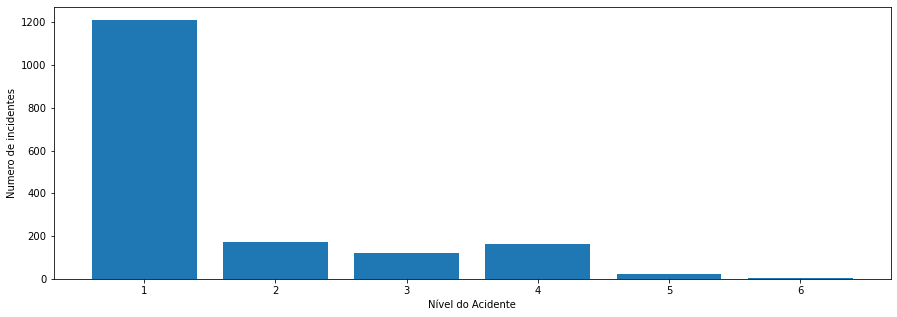

In [7]:
# Plotando incidentes por Nível do Acidente
nivel_count = csv_dd13.groupby('Nível do Acidente').count()
plt.figure(figsize=(15,5))
plt.bar(nivel_count.index.values, nivel_count['Descrição'])
plt.xlabel('Nível do Acidente')
plt.ylabel('Numero de incidentes')
plt.show()

In [8]:
# Stopwords
stop_words = set(stopwords.words('portuguese') + list(punctuation))
# Removendo stopwords
def removeStopWord(text):
    sentence = word_tokenize(text)
    filtered_sentence = " ".join(str(w.lower()) for w in sentence if not w in stop_words)
    return filtered_sentence

In [10]:
# Funcao para transformar para dense
from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


 ### Teste de classificação para preencher o nível do acidente

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, precision_score, classification_report
from sklearn.compose import ColumnTransformer

X = csv_dd13['Descrição']
y = csv_dd13['Nível do Acidente']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 13)

In [12]:
modelLDA = Pipeline(steps = [('tf', TfidfVectorizer()), 
                              ('to_dense', DenseTransformer()), 
                              ('lda', LinearDiscriminantAnalysis())])

In [13]:
modelLDA.fit(X_train, y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('to_dense',
                 <__main__.DenseTransformer object at 0x7fc7ac5817f0>),
                ('lda', LinearDiscriminantAnalysis())])

In [14]:
modelLDA.decision_function(X)

array([[    7.56510961,   -19.9275806 ,  -869.02584731,   -28.41233249,
         -113.51702202,  -417.3993714 ],
       [    7.41470628,   -19.79679739,  -869.17625064,   -27.46908401,
         -112.72654681,  -407.06853736],
       [   30.77345523,   -17.45602111, -1089.61335209,   -32.73410077,
         -182.366452  ,  -503.37138912],
       ...,
       [    8.36067813,   -34.68289586,  -868.23027879,   -20.9179278 ,
         -114.91483463,  -426.58345853],
       [    7.40773622,   -19.65599878,  -869.1832207 ,   -27.60310431,
         -112.42320423,  -404.21241456],
       [    7.35130397,   -19.99990499,  -869.23965295,   -26.32103926,
         -116.4652104 ,  -407.69531536]])

In [15]:
score=modelLDA.score(X_train, y_train)
ypred=modelLDA.predict(X_test)
cm = confusion_matrix(y_test, ypred)

print("Score: ",score)
print(cm)
print(classification_report(y_test, ypred))

Score:  0.9822033898305085
[[215  54   6  69   6   1]
 [ 33  12   2  13   3   0]
 [ 11   7   2   9   5   0]
 [ 13   6   1  24   4   0]
 [  6   0   0   2   0   0]
 [  0   0   0   1   1   0]]
              precision    recall  f1-score   support

         1.0       0.77      0.61      0.68       351
         2.0       0.15      0.19      0.17        63
         3.0       0.18      0.06      0.09        34
         4.0       0.20      0.50      0.29        48
         5.0       0.00      0.00      0.00         8
         6.0       0.00      0.00      0.00         2

    accuracy                           0.50       506
   macro avg       0.22      0.23      0.21       506
weighted avg       0.59      0.50      0.53       506

